In [1]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

2023-01-21 17:06:29.461025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-21 17:06:29.461099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-21 17:06:29.461108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure t

### Paths

- celeba_path: path to the directory with 224x224 cropped pictures from celebA dataset

In [3]:
celeba_path = Path('../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../Dataset/celeb_identity_processed.txt')

precalculated_pairs_path = Path('../../Dataset/pairs_precalculated.csv')

### Hyperparameters

- Hyperparameters used in this model

In [4]:
pair_count = 1000
train_size = 0.7

network_input_shape = (224, 224, 3)

batch_size = 16
margin = 0.5
lr = 1e-4

### Creating pairs

- load celeba_identity_path dataset with the information about the dataset

In [5]:
df_identity = pd.read_csv(
    celeba_identity_path,
    sep=",",
    names=["image", "identity"],
    header=0,
    dtype=str
)

In [6]:
def create_n_pairs(df_identity, n):
    pairs = []

    for pair in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        keepGoing = True
        while (keepGoing):
            anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
            keepGoing = (anchor == positive)

        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative

        pairs.append([anchor, positive, 1])
        pairs.append([anchor, negative, 0])

    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

- creating n-pair dataframe

In [7]:
pairs = create_n_pairs(df_identity, pair_count)
pairs.head()

,left,right,label
0,../../Dataset/img_celeba_cropped/122060.jpg,../../Dataset/img_celeba_cropped/101078.jpg,1
1,../../Dataset/img_celeba_cropped/122060.jpg,../../Dataset/img_celeba_cropped/014453.jpg,0
2,../../Dataset/img_celeba_cropped/119880.jpg,../../Dataset/img_celeba_cropped/092496.jpg,1
3,../../Dataset/img_celeba_cropped/119880.jpg,../../Dataset/img_celeba_cropped/185977.jpg,0
4,../../Dataset/img_celeba_cropped/122643.jpg,../../Dataset/img_celeba_cropped/111126.jpg,1


In [8]:
pairs.shape

(2000, 3)

### Visualize pairs

- first 8 pairs of the generated dataset
- even indeces are same people, odd are the different ones

In [9]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(8, 2)
    for i in range(8):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

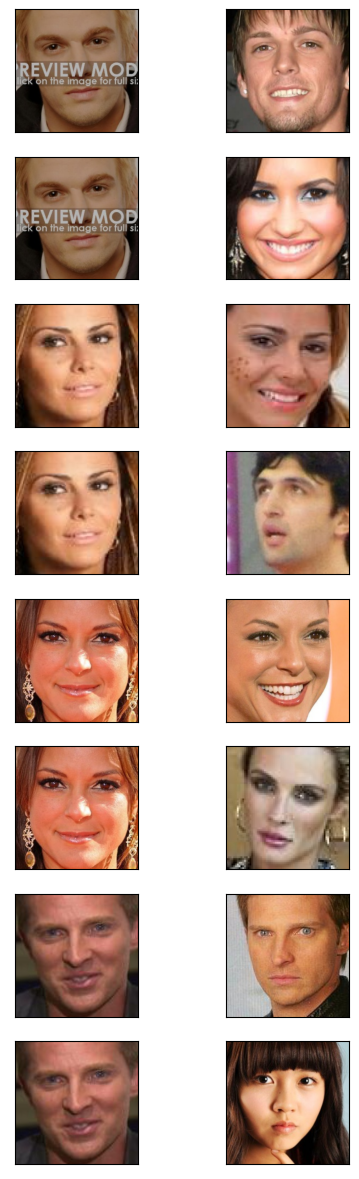

In [10]:
visualize_pairs(pairs)

### TF Pipeline

- VGG_FACE requires numpy array as an input, therefore TF API functions for preprocessing is not used in this case

In [11]:
# reshape flag expands dimension of the img, needed for model.predict
def convert_to_img(img_path, reshape=False):
    img = cv2.imread(img_path)
    img = img.astype("float32")
    img = preprocess_input(img, version=2)

    if reshape is True:
        img = img[np.newaxis, ...]

    return img


def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [12]:
def create_dataset(df, for_prediction=False):

    left = df["left"].apply(convert_to_img, reshape=for_prediction)
    right = df["right"].apply(convert_to_img, reshape=for_prediction)
    left = left.tolist()
    right = right.tolist()

    feature_ds = tf.data.Dataset.from_tensor_slices((left, right))

    labels_ds = tf.data.Dataset.from_tensor_slices(df['label'].values)
    labels_ds = labels_ds.map(label_preprocessing)

    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))

    return dataset

In [13]:
dataset = create_dataset(pairs)

In [14]:
train_ds = dataset.take(round(pair_count * train_size))
val_ds = dataset.skip(round(pair_count * train_size))

### Performance optimization

- batching, batch size 16, parallel calls set to AUTOTONE
- prefetching buffer size set to AUTOTUNE as well
- pictures are cached in memory

In [15]:
train_ds = train_ds \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

val_ds = val_ds \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

# Training a new model

### VGG_FACE embedding

- keras vgg_face model used are a feature extractor
- feature vector is 512 neurons wide. 256 FV was giving worse performance, however increasing the FV width to 1024 did not show any significant improvements
- adding more layers with non-linear activation did not improve performance
- adding batch normalization layer did not improve performance as well

In [16]:
def vgg_face_tower():
    input = layers.Input(network_input_shape)

    base = VGGFace(
        input_tensor=input,
        model="resnet50",
        input_shape=network_input_shape,
        include_top=False
    )

    for layer in base.layers:
        layer.trainable = False

    model = layers.Flatten()(base.output)

    output = layers.Dense(512)(model)

    return Model(input, output, name="vgg_face_tower")

In [17]:
feature_extractor = vgg_face_tower()

In [18]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [19]:
# initializing the left "tower"
left_tower_input = layers.Input(
    shape=network_input_shape,
    name="left_tower"
)

left_tower = feature_extractor(left_tower_input)


# initializing the right "tower"
right_tower_input = layers.Input(
    shape=network_input_shape,
    name="right_tower"
)

right_tower = feature_extractor(right_tower_input)


# merge layer
merge_layer = layers.Lambda(
    euclidean_distance,
    name="lambda_layer"
)([left_tower, right_tower])


model = Model([left_tower_input, right_tower_input], merge_layer, name="contrastive_loss_model")

In [20]:
def cont_loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

- CL margin of 0.5 seems to be have higher performance by 2-3 percent compared to margin loss 1 or 0.2
- optimal learning rate of 1e-4 was chosen as it does not cause model to overfit and training is significatnly faster compared to lr of 1e-5

In [21]:
model.compile(loss=cont_loss(margin), optimizer=Adam(learning_rate=lr))
model.summary()

Model: "contrastive_loss_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg_face_tower (Functional)    (None, 512)          24610240    ['left_tower[0][0]',             
                                                                  'right_towe

In [22]:
# plot_model(model, show_shapes=True)

### Callbacks

- early stopping and lr_scheduler_reduce used when training on a large number of epochs so the model

In [23]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    # histogram_freq=1,
    # embeddings_freq=1,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler_reduce = ReduceLROnPlateau(factor=0.5, patience=5)

In [24]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
]

In [25]:
%time
model_fit = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks_list,
    epochs=50,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/50
44/44 [==============================] - 22s 317ms/step - loss: 3178.1951 - val_loss: 2852.2173 - lr: 1.0000e-04
Epoch 2/50
44/44 [==============================] - 10s 223ms/step - loss: 2335.6301 - val_loss: 2441.5115 - lr: 1.0000e-04
Epoch 3/50
44/44 [==============================] - 10s 225ms/step - loss: 1817.9382 - val_loss: 2160.9917 - lr: 1.0000e-04
Epoch 4/50
44/44 [==============================] - 10s 225ms/step - loss: 1463.3252 - val_loss: 1963.1484 - lr: 1.0000e-04
Epoch 5/50
44/44 [==============================] - 10s 226ms/step - loss: 1211.0785 - val_loss: 1818.4211 - lr: 1.0000e-04
Epoch 6/50
44/44 [==============================] - 10s 227ms/step - loss: 1024.3800 - val_loss: 1708.6755 - lr: 1.0000e-04
Epoch 7/50
44/44 [==============================] - 10s 227ms/step - loss: 881.0039 - val_loss: 1622.7073 - lr: 1.0000e-04
Epoch 8/50
44/44 [==============================] - 10s 228ms/step - 

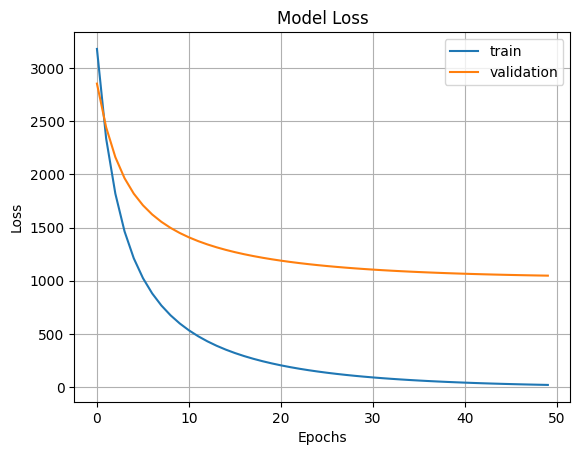

In [26]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Save model

- this script allows us to save either the whole model or just the embedding for feature extraction

In [49]:
save_path = 'saved_models'

#### Save whole model

In [50]:
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'{save_path}/{model_version}'
model.save(model_path)
model.save_weights("model_path")

INFO:tensorflow:Assets written to: saved_models/contrastive_loss_model-20230121-172210/assets


INFO:tensorflow:Assets written to: saved_models/contrastive_loss_model-20230121-172210/assets


#### Saving just the embedding for predictions

In [29]:
# model_version = f'embedding-{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

# model_path = f'{save_path}/{model_version}'
# feature_extractor.save(model_path, include_optimizer=False)
# feature_extractor.save_weights("model_path")

# b) Loading saved model

In [52]:
!ls ./saved_models

contrastive_loss_50epochs_85  contrastive_loss_model-final


#### Loading whole model

- loading contrastive_loss as a custom object

In [53]:
model = load_model('saved_models/contrastive_loss_model-final',
                   custom_objects={'contrastive_loss': cont_loss})

## Tensorboard

- launching tensorboard straight from the notebook

In [32]:
# %load_ext tensorboard
# %tensorboard --logdir=logs

# Predictions

- prediction cutoff will be calculated from 500 random pairs

In [33]:
test_pairs = create_n_pairs(df_identity, 500)

In [34]:
pairs.head(6)

,left,right,label
0,../../Dataset/img_celeba_cropped/122060.jpg,../../Dataset/img_celeba_cropped/101078.jpg,1
1,../../Dataset/img_celeba_cropped/122060.jpg,../../Dataset/img_celeba_cropped/014453.jpg,0
2,../../Dataset/img_celeba_cropped/119880.jpg,../../Dataset/img_celeba_cropped/092496.jpg,1
3,../../Dataset/img_celeba_cropped/119880.jpg,../../Dataset/img_celeba_cropped/185977.jpg,0
4,../../Dataset/img_celeba_cropped/122643.jpg,../../Dataset/img_celeba_cropped/111126.jpg,1
5,../../Dataset/img_celeba_cropped/122643.jpg,../../Dataset/img_celeba_cropped/106363.jpg,0


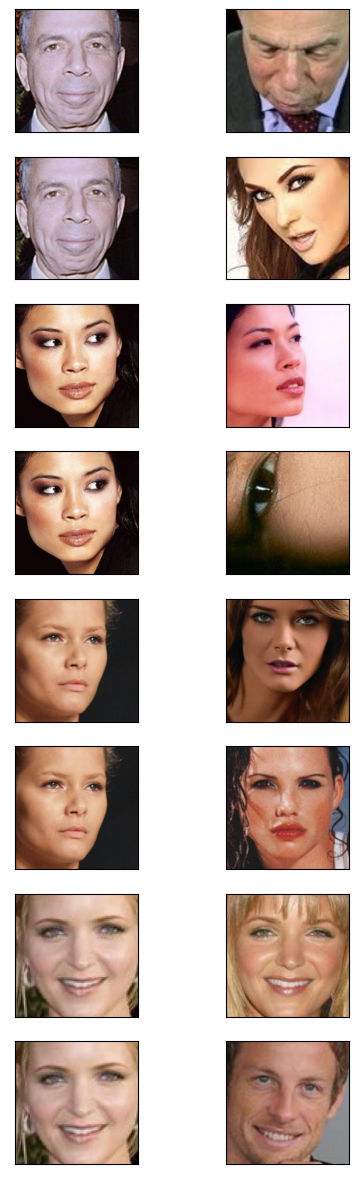

In [35]:
visualize_pairs(test_pairs)

- converting random pairs into the TF dataset
- for_prediction flag set to True (img will have one extra dimentsion necessary for `model.predict`)

In [36]:
test_ds = create_dataset(test_pairs, for_prediction=True)
test_labels = test_pairs['label']

- euclidian distances as predictions

In [54]:
predictions = model.predict(test_ds)

1000/1000 [==============================] - 15s 13ms/step


- separate positive and negative pair distances

In [55]:
positive_distances = predictions[0::2].flatten()
negative_distances = predictions[1::2].flatten()

- count and compare positive and negative distances distributions
- middle point between positive and megative distances mean is selected as a cutoff for predictions
- dist < cutoff => Same
- dist > cutoff => Different

In [56]:
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    500.000000
mean      34.140835
std        6.111130
min       12.438922
25%       30.113975
50%       34.027832
75%       38.017078
max       54.185219
dtype: float64

In [57]:
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    500.000000
mean      45.264507
std        3.821374
min       34.350788
25%       42.973393
50%       45.134041
75%       47.528339
max       61.990566
dtype: float64

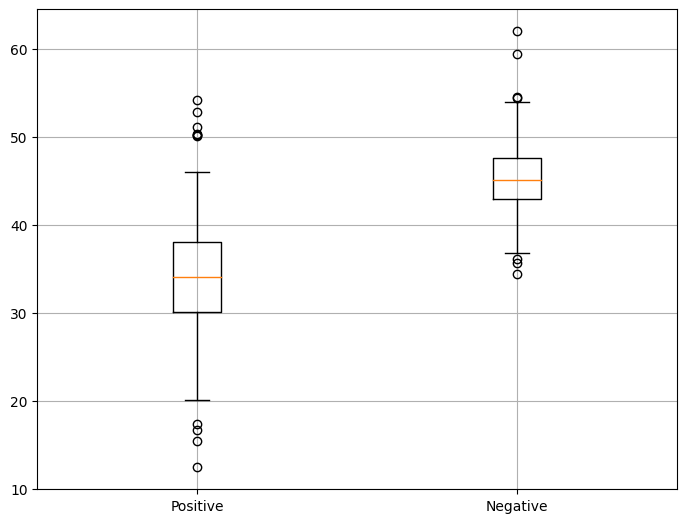

In [58]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [59]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [60]:
cutoff = (positive_mean + negative_mean)/2
cutoff

39.70267105102539

### Model accuracy
- how well the selected cutoff separates between positive and negative pairs

In [61]:
test_accuracy, y_pred = compute_accuracy(test_labels, predictions, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 87.90%


<AxesSubplot: >

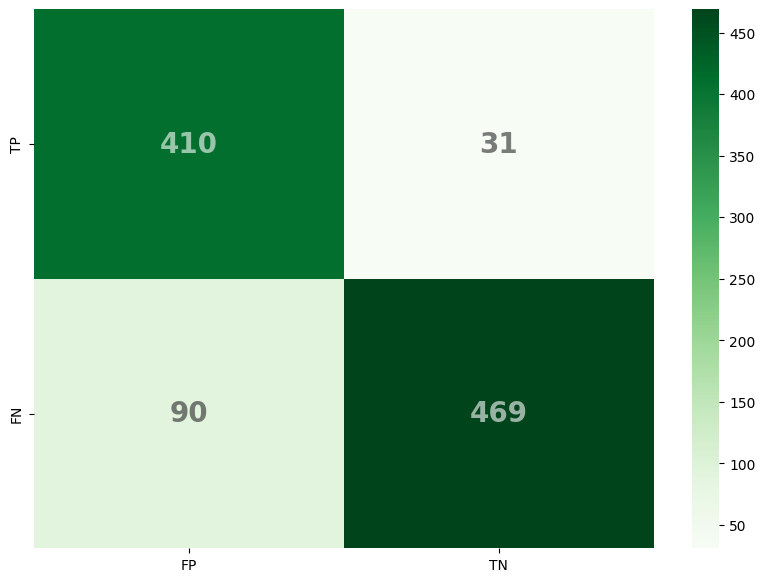

In [62]:
c_matrix = confusion_matrix(y_pred, test_labels, labels=[1, 0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10, 7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
           annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
           fmt='g')

### Classification report with extra metrics

In [63]:
report = classification_report(y_pred, test_labels)
print(report)

              precision    recall  f1-score   support

       False       0.94      0.84      0.89       559
        True       0.82      0.93      0.87       441

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



### Visualize the predictions

In [64]:
def visualize(pairs, labels, cutoff, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {}".format('Same' if labels.iloc[i] == 1 else 'Different',
                                                      'Same' if predictions[i][0] < cutoff else 'Different'))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

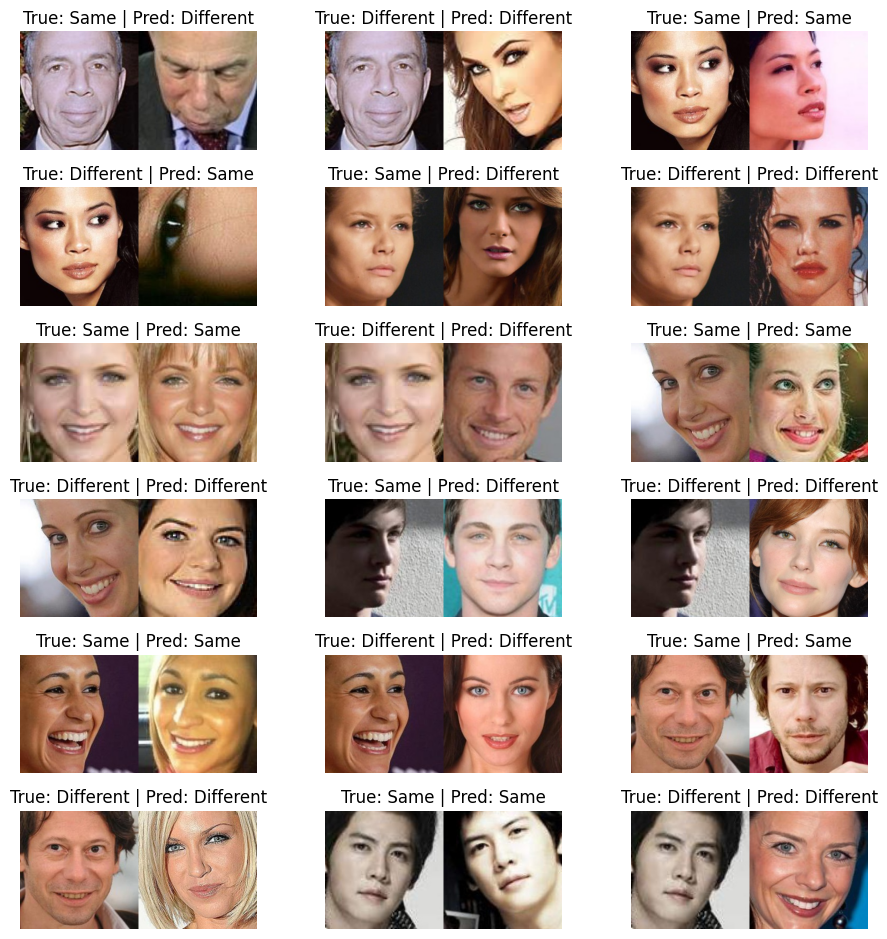

In [65]:
visualize(
    test_pairs,
    test_pairs['label'],
    cutoff,
    to_show=18,
    num_col=3,
    predictions=predictions,
    test=True
)